## This is a test file to check validity of raw data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client, Variable
%matplotlib inline

In [2]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [3]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='Blues')

In [4]:
# Getting the data

client = Client()

mfdataDIR1 = './data/GPM_data/gpm_2009/*.nc4'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True) # this is GPM IMERG data

In [5]:
ds1 = ds1.drop_dims(['lonv', 'latv', 'nv'])
ds1 = ds1.transpose('time', 'lat', 'lon')

In [6]:
ds1

<xarray.Dataset>
Dimensions:             (time: 17520, lon: 401, lat: 401)
Coordinates:
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * time                (time) object 2009-01-01 00:00:00 ... 2009-12-31 23:3...
Data variables:
    precipitationCal    (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    precipitationUncal  (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    IRprecipitation     (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2021-10-15 06:51:17 GMT Hyrax-1.16.3 htt...

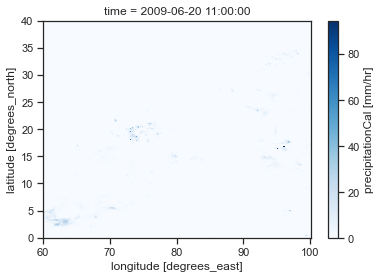

In [7]:
ds1.precipitationCal.sel(time = "2009-06-20 11:00:00").plot()

## This is temporary stuff

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
%matplotlib inline
%config IPCompleter.greedy = True

In [3]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


In [6]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q = 0.5)

In [7]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Sat, 16 Oct 2021   No. Observations:                  235
Time:                        18:33:05   Df Residuals:                      233
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586
==============================================================================

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
res.prsquared

0.6206